In [17]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import os
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from matplotlib import pyplot as plt
import torchvision.models as models
import random
from PIL import Image
from torch.utils.data import Dataset

In [18]:
# 设置数据集路径
total_dir = "/Users/fcccasa/Downloads/R/img"

# 定义数据预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 加载数据集
total_data = datasets.ImageFolder(total_dir, transform)

# 获取类别并按数字顺序排序
def sort_key(class_name):
    # 尝试将类别名称转换为整数，若失败则返回原字符串
    try:
        return int(class_name)  # 如果类别是数字，则按数字排序
    except ValueError:
        return class_name  # 如果类别是非数字，则按字母排序

sorted_classes = sorted(total_data.classes, key=sort_key)

# 更新 ImageFolder 的 class_to_idx 字典
total_data.class_to_idx = {cls: idx for idx, cls in enumerate(sorted_classes)}

print("Sorted Classes:", sorted_classes)

# 使用排序后的类名创建训练集和测试集索引
train_indices = []
test_indices = []

# 遍历数据集中的每个类别（文件夹）
for class_idx in range(len(sorted_classes)):
    # 获取当前类别所有图像的索引
    class_indices = [i for i, label in enumerate(total_data.targets) if label == class_idx]
    
    # 分割：前40个图像为训练集，剩下的为测试集
    train_indices.extend(class_indices[:40])
    test_indices.extend(class_indices[40:])

# 使用索引创建训练集和测试集
train_dataset = torch.utils.data.Subset(total_data, train_indices)
test_dataset = torch.utils.data.Subset(total_data, test_indices)

# 打印训练集和测试集的大小
print(f'训练集大小: {len(train_dataset)}')
print(f'测试集大小: {len(test_dataset)}')


Sorted Classes: ['-250', '-249', '-248', '-247', '-246', '-245', '-244', '-243', '-242', '-241', '-240', '-239', '-238', '-237', '-236', '-235', '-234', '-233', '-232', '-231', '-230', '-229', '-228', '-227', '-226', '-225', '-224', '-223', '-222', '-221', '-220', '-219', '-218', '-217', '-216', '-215', '-214', '-213', '-212', '-211', '-210', '-209', '-208', '-207', '-206', '-205', '-204', '-203', '-202', '-201', '-200', '-199', '-198', '-197', '-196', '-195', '-194', '-193', '-192', '-191', '-190', '-189', '-188', '-187', '-186', '-185', '-184', '-183', '-182', '-181', '-180', '-179', '-178', '-177', '-176', '-175', '-174', '-173', '-172', '-171', '-170', '-169', '-168', '-167', '-166', '-165', '-164', '-163', '-162', '-161', '-160', '-159', '-158', '-157', '-156', '-155', '-154', '-153', '-152', '-151', '-150', '-149', '-148', '-147', '-146', '-145', '-144', '-143', '-142', '-141', '-140', '-139', '-138', '-137', '-136', '-135', '-134', '-133', '-132', '-131', '-130', '-129', '-128',

In [19]:
train_dataloader = DataLoader(train_dataset, batch_size=40, shuffle=True, num_workers=1)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=1)


In [20]:
# 初始化
num_classes = 1

MAX_EPOCH = 20     
LR = 0.001         
log_interval = 10    # 每隔 1 个 训练批次（或 epoch）记录一次训练日志。 表示训练过程中，控制打印训练信息的频率。
val_interval = 1    # 每隔 1 个 epoch 进行一次验证集的评估。验证集的评估是为了监控模型在验证集上的表现，从而避免过拟合。
classes = 1         # 分类任务的类别数为 2。
start_epoch = -1     
lr_decay_step = 10   # 表示学习率的衰减步长。 每隔一定的 epoch（如 1）对学习率进行衰减，通常是为了使模型在后期更稳定地收敛。
                    # 可结合优化器的学习率调度策略（如 StepLR）使用。

In [21]:
device = device = torch.device("mps")
res_model = models.resnet18(pretrained=True)  # 使用预训练权重
# 获取 ResNet 的最后一层输入特征数
num_ftrs = res_model.fc.in_features  # 获取fc层的输入特征数
res_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 128),           # 将输入特征维度映射到4096
    nn.ReLU(),
    nn.Linear(128, 1)                    # 输出为1，进行回归预测任务
)
print(num_ftrs)
res_model.to(device)

512


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
criterion = nn.L1Loss()

In [23]:
optimizer = torch.optim.Adam(res_model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step, gamma=0.1)

In [24]:
train_curve = list() 
valid_curve = list()

for epoch in range(start_epoch + 1, MAX_EPOCH):

    loss_mean = 0.
    correct = 0.
    total = 0.

    res_model.train() # 将模型切换到训练模式，启用 dropout 等操作。
    for i, data in enumerate(train_dataloader):
        # 遍历训练数据加载器，data 包含一个批次的 inputs（输入图像）和 labels（对应的标签）。

        # forward
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = res_model(inputs)

        # 调整标签的形状
        labels = labels.view(-1, 1)  # 确保标签的形状与输出一致

        # backward
        optimizer.zero_grad()
        # 清空上一批次的梯度，防止累积。
        loss = criterion(outputs, labels)
        loss.backward()
        # 通过自动求导计算梯度。

        # update weights
        optimizer.step()
        # 使用优化器根据计算出的梯度更新模型参数。

        # 打印训练信息
        loss_mean += loss.item()        # 获取当前批次的损失值。
        train_curve.append(loss.item()) # 将当前批次的损失值记录到 train_curve。
        if (i+1) % log_interval == 0:
            loss_mean = loss_mean / log_interval
            print("Training: Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f}".format(
                epoch, MAX_EPOCH, i+1, len(train_dataloader), loss_mean))
            loss_mean = 0.

    scheduler.step()  # 更新学习率 调用学习率调度器，根据设置调整当前学习率（如按一定步长下降）。

    # validate the model
    if (epoch+1) % val_interval == 0:

        correct_val = 0.
        total_val = 0.
        loss_val = 0.
        res_model.eval() 
        
        # 禁用自动求导，减少内存占用，加速计算。
        with torch.no_grad():
            for j, data in enumerate(test_dataloader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = res_model(inputs)
               
                # 调整标签的形状
                labels = labels.view(-1, 1)  # 确保标签的形状与输出一致

                loss = criterion(outputs, labels)

                loss_val += loss.item()

            loss_val_mean = loss_val / len(test_dataloader)
            valid_curve.append(loss_val_mean)
            print("Valid: Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f}".format(
                epoch, MAX_EPOCH, j+1, len(test_dataloader), loss_val_mean))

        res_model.train()  # 将模型切换回训练模式


python(48227) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Training: Epoch[000/020] Iteration[010/501] Loss: 238.8234
Training: Epoch[000/020] Iteration[020/501] Loss: 208.3223
Training: Epoch[000/020] Iteration[030/501] Loss: 187.8736
Training: Epoch[000/020] Iteration[040/501] Loss: 146.2350
Training: Epoch[000/020] Iteration[050/501] Loss: 81.2386
Training: Epoch[000/020] Iteration[060/501] Loss: 50.6772
Training: Epoch[000/020] Iteration[070/501] Loss: 43.5607
Training: Epoch[000/020] Iteration[080/501] Loss: 45.5455
Training: Epoch[000/020] Iteration[090/501] Loss: 40.0129
Training: Epoch[000/020] Iteration[100/501] Loss: 34.9232
Training: Epoch[000/020] Iteration[110/501] Loss: 32.0094
Training: Epoch[000/020] Iteration[120/501] Loss: 38.4783
Training: Epoch[000/020] Iteration[130/501] Loss: 32.1578
Training: Epoch[000/020] Iteration[140/501] Loss: 30.7788
Training: Epoch[000/020] Iteration[150/501] Loss: 33.4160
Training: Epoch[000/020] Iteration[160/501] Loss: 26.5570
Training: Epoch[000/020] Iteration[170/501] Loss: 23.9600
Training: 

python(48800) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Valid: Epoch[000/020] Iteration[501/501] Loss: 20.9481


python(48897) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Training: Epoch[001/020] Iteration[010/501] Loss: 22.0532
Training: Epoch[001/020] Iteration[020/501] Loss: 27.7960
Training: Epoch[001/020] Iteration[030/501] Loss: 18.9813
Training: Epoch[001/020] Iteration[040/501] Loss: 25.1819
Training: Epoch[001/020] Iteration[050/501] Loss: 20.7939
Training: Epoch[001/020] Iteration[060/501] Loss: 22.0902
Training: Epoch[001/020] Iteration[070/501] Loss: 18.3003
Training: Epoch[001/020] Iteration[080/501] Loss: 21.3319
Training: Epoch[001/020] Iteration[090/501] Loss: 25.1870
Training: Epoch[001/020] Iteration[100/501] Loss: 24.5501
Training: Epoch[001/020] Iteration[110/501] Loss: 25.8687
Training: Epoch[001/020] Iteration[120/501] Loss: 22.0448
Training: Epoch[001/020] Iteration[130/501] Loss: 20.6532
Training: Epoch[001/020] Iteration[140/501] Loss: 23.2834
Training: Epoch[001/020] Iteration[150/501] Loss: 26.0089
Training: Epoch[001/020] Iteration[160/501] Loss: 21.1507
Training: Epoch[001/020] Iteration[170/501] Loss: 22.9160
Training: Epoc

python(49521) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Valid: Epoch[001/020] Iteration[501/501] Loss: 16.4022


python(49587) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Training: Epoch[002/020] Iteration[010/501] Loss: 15.4716
Training: Epoch[002/020] Iteration[020/501] Loss: 16.9876
Training: Epoch[002/020] Iteration[030/501] Loss: 16.4757
Training: Epoch[002/020] Iteration[040/501] Loss: 13.3934
Training: Epoch[002/020] Iteration[050/501] Loss: 19.9617
Training: Epoch[002/020] Iteration[060/501] Loss: 16.5978
Training: Epoch[002/020] Iteration[070/501] Loss: 17.4290
Training: Epoch[002/020] Iteration[080/501] Loss: 19.2206
Training: Epoch[002/020] Iteration[090/501] Loss: 15.3631
Training: Epoch[002/020] Iteration[100/501] Loss: 16.6155
Training: Epoch[002/020] Iteration[110/501] Loss: 16.4806
Training: Epoch[002/020] Iteration[120/501] Loss: 18.0277
Training: Epoch[002/020] Iteration[130/501] Loss: 14.2841
Training: Epoch[002/020] Iteration[140/501] Loss: 16.1954
Training: Epoch[002/020] Iteration[150/501] Loss: 14.4718
Training: Epoch[002/020] Iteration[160/501] Loss: 14.1210
Training: Epoch[002/020] Iteration[170/501] Loss: 14.9896
Training: Epoc

python(50121) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Valid: Epoch[002/020] Iteration[501/501] Loss: 14.7543


python(50184) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Training: Epoch[003/020] Iteration[010/501] Loss: 13.8210
Training: Epoch[003/020] Iteration[020/501] Loss: 16.5366
Training: Epoch[003/020] Iteration[030/501] Loss: 17.1545
Training: Epoch[003/020] Iteration[040/501] Loss: 12.2355
Training: Epoch[003/020] Iteration[050/501] Loss: 14.7445
Training: Epoch[003/020] Iteration[060/501] Loss: 12.2521
Training: Epoch[003/020] Iteration[070/501] Loss: 13.1738
Training: Epoch[003/020] Iteration[080/501] Loss: 11.8454
Training: Epoch[003/020] Iteration[090/501] Loss: 11.4668
Training: Epoch[003/020] Iteration[100/501] Loss: 15.9831
Training: Epoch[003/020] Iteration[110/501] Loss: 14.0516
Training: Epoch[003/020] Iteration[120/501] Loss: 13.9923
Training: Epoch[003/020] Iteration[130/501] Loss: 13.0644
Training: Epoch[003/020] Iteration[140/501] Loss: 11.0713
Training: Epoch[003/020] Iteration[150/501] Loss: 12.9820
Training: Epoch[003/020] Iteration[160/501] Loss: 10.6824
Training: Epoch[003/020] Iteration[170/501] Loss: 14.0987
Training: Epoc

python(50753) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Valid: Epoch[003/020] Iteration[501/501] Loss: 12.7043


python(50814) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Training: Epoch[004/020] Iteration[010/501] Loss: 11.7257
Training: Epoch[004/020] Iteration[020/501] Loss: 7.7379
Training: Epoch[004/020] Iteration[030/501] Loss: 11.4048
Training: Epoch[004/020] Iteration[040/501] Loss: 11.2533
Training: Epoch[004/020] Iteration[050/501] Loss: 10.9073
Training: Epoch[004/020] Iteration[060/501] Loss: 10.8476
Training: Epoch[004/020] Iteration[070/501] Loss: 11.4002
Training: Epoch[004/020] Iteration[080/501] Loss: 11.9448
Training: Epoch[004/020] Iteration[090/501] Loss: 13.1945
Training: Epoch[004/020] Iteration[100/501] Loss: 11.4955
Training: Epoch[004/020] Iteration[110/501] Loss: 12.6401
Training: Epoch[004/020] Iteration[120/501] Loss: 10.2714
Training: Epoch[004/020] Iteration[130/501] Loss: 11.4772
Training: Epoch[004/020] Iteration[140/501] Loss: 10.4336
Training: Epoch[004/020] Iteration[150/501] Loss: 14.3970
Training: Epoch[004/020] Iteration[160/501] Loss: 13.4623
Training: Epoch[004/020] Iteration[170/501] Loss: 11.9761
Training: Epoch

python(51314) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Valid: Epoch[004/020] Iteration[501/501] Loss: 12.5175


python(51378) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Training: Epoch[005/020] Iteration[010/501] Loss: 12.6548
Training: Epoch[005/020] Iteration[020/501] Loss: 9.8428
Training: Epoch[005/020] Iteration[030/501] Loss: 7.2569
Training: Epoch[005/020] Iteration[040/501] Loss: 12.8381
Training: Epoch[005/020] Iteration[050/501] Loss: 15.2437
Training: Epoch[005/020] Iteration[060/501] Loss: 13.4848
Training: Epoch[005/020] Iteration[070/501] Loss: 18.0235
Training: Epoch[005/020] Iteration[080/501] Loss: 14.5941
Training: Epoch[005/020] Iteration[090/501] Loss: 11.5216
Training: Epoch[005/020] Iteration[100/501] Loss: 10.1568
Training: Epoch[005/020] Iteration[110/501] Loss: 10.9613
Training: Epoch[005/020] Iteration[120/501] Loss: 9.1112
Training: Epoch[005/020] Iteration[130/501] Loss: 11.2066
Training: Epoch[005/020] Iteration[140/501] Loss: 12.5009
Training: Epoch[005/020] Iteration[150/501] Loss: 12.7571
Training: Epoch[005/020] Iteration[160/501] Loss: 10.1717
Training: Epoch[005/020] Iteration[170/501] Loss: 11.1188
Training: Epoch[0

python(51850) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Valid: Epoch[005/020] Iteration[501/501] Loss: 10.8250


python(51921) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Training: Epoch[006/020] Iteration[010/501] Loss: 10.8015
Training: Epoch[006/020] Iteration[020/501] Loss: 9.1599
Training: Epoch[006/020] Iteration[030/501] Loss: 11.9721
Training: Epoch[006/020] Iteration[040/501] Loss: 10.8907
Training: Epoch[006/020] Iteration[050/501] Loss: 9.4159
Training: Epoch[006/020] Iteration[060/501] Loss: 9.0384
Training: Epoch[006/020] Iteration[070/501] Loss: 7.9468
Training: Epoch[006/020] Iteration[080/501] Loss: 10.9773
Training: Epoch[006/020] Iteration[090/501] Loss: 9.8638
Training: Epoch[006/020] Iteration[100/501] Loss: 9.4479
Training: Epoch[006/020] Iteration[110/501] Loss: 9.2185
Training: Epoch[006/020] Iteration[120/501] Loss: 9.7100
Training: Epoch[006/020] Iteration[130/501] Loss: 9.6613
Training: Epoch[006/020] Iteration[140/501] Loss: 6.9416
Training: Epoch[006/020] Iteration[150/501] Loss: 9.5139
Training: Epoch[006/020] Iteration[160/501] Loss: 12.2623
Training: Epoch[006/020] Iteration[170/501] Loss: 9.9908
Training: Epoch[006/020] I

python(52400) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Valid: Epoch[006/020] Iteration[501/501] Loss: 9.2190


python(52461) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Training: Epoch[007/020] Iteration[010/501] Loss: 6.7900
Training: Epoch[007/020] Iteration[020/501] Loss: 7.5766
Training: Epoch[007/020] Iteration[030/501] Loss: 8.8937
Training: Epoch[007/020] Iteration[040/501] Loss: 8.9897
Training: Epoch[007/020] Iteration[050/501] Loss: 10.2976
Training: Epoch[007/020] Iteration[060/501] Loss: 12.5946
Training: Epoch[007/020] Iteration[070/501] Loss: 8.8265
Training: Epoch[007/020] Iteration[080/501] Loss: 9.3521
Training: Epoch[007/020] Iteration[090/501] Loss: 7.2001
Training: Epoch[007/020] Iteration[100/501] Loss: 8.3544
Training: Epoch[007/020] Iteration[110/501] Loss: 7.4457
Training: Epoch[007/020] Iteration[120/501] Loss: 7.7033
Training: Epoch[007/020] Iteration[130/501] Loss: 9.1867
Training: Epoch[007/020] Iteration[140/501] Loss: 7.5564
Training: Epoch[007/020] Iteration[150/501] Loss: 10.0516
Training: Epoch[007/020] Iteration[160/501] Loss: 8.2025
Training: Epoch[007/020] Iteration[170/501] Loss: 14.5456
Training: Epoch[007/020] It

python(52922) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Valid: Epoch[007/020] Iteration[501/501] Loss: 11.5732


python(52982) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Training: Epoch[008/020] Iteration[010/501] Loss: 9.4077
Training: Epoch[008/020] Iteration[020/501] Loss: 10.6807
Training: Epoch[008/020] Iteration[030/501] Loss: 7.3281
Training: Epoch[008/020] Iteration[040/501] Loss: 9.3661
Training: Epoch[008/020] Iteration[050/501] Loss: 10.5932
Training: Epoch[008/020] Iteration[060/501] Loss: 8.5461
Training: Epoch[008/020] Iteration[070/501] Loss: 9.1463
Training: Epoch[008/020] Iteration[080/501] Loss: 7.1961
Training: Epoch[008/020] Iteration[090/501] Loss: 11.7326
Training: Epoch[008/020] Iteration[100/501] Loss: 11.6934
Training: Epoch[008/020] Iteration[110/501] Loss: 8.5837
Training: Epoch[008/020] Iteration[120/501] Loss: 8.8147
Training: Epoch[008/020] Iteration[130/501] Loss: 6.4637
Training: Epoch[008/020] Iteration[140/501] Loss: 6.0278
Training: Epoch[008/020] Iteration[150/501] Loss: 8.3779
Training: Epoch[008/020] Iteration[160/501] Loss: 8.7051
Training: Epoch[008/020] Iteration[170/501] Loss: 8.6559
Training: Epoch[008/020] It

python(53449) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Valid: Epoch[008/020] Iteration[501/501] Loss: 8.7671


python(53532) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Training: Epoch[009/020] Iteration[010/501] Loss: 9.9748
Training: Epoch[009/020] Iteration[020/501] Loss: 7.2753
Training: Epoch[009/020] Iteration[030/501] Loss: 8.9928
Training: Epoch[009/020] Iteration[040/501] Loss: 7.1571
Training: Epoch[009/020] Iteration[050/501] Loss: 8.3721
Training: Epoch[009/020] Iteration[060/501] Loss: 7.2343
Training: Epoch[009/020] Iteration[070/501] Loss: 7.4626
Training: Epoch[009/020] Iteration[080/501] Loss: 10.4263
Training: Epoch[009/020] Iteration[090/501] Loss: 6.5545
Training: Epoch[009/020] Iteration[100/501] Loss: 8.7681
Training: Epoch[009/020] Iteration[110/501] Loss: 8.6162
Training: Epoch[009/020] Iteration[120/501] Loss: 7.8678
Training: Epoch[009/020] Iteration[130/501] Loss: 8.8307
Training: Epoch[009/020] Iteration[140/501] Loss: 7.2141
Training: Epoch[009/020] Iteration[150/501] Loss: 7.3186
Training: Epoch[009/020] Iteration[160/501] Loss: 8.3244
Training: Epoch[009/020] Iteration[170/501] Loss: 7.6228
Training: Epoch[009/020] Itera

python(53996) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Valid: Epoch[009/020] Iteration[501/501] Loss: 13.8604


python(54059) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Training: Epoch[010/020] Iteration[010/501] Loss: 6.5754
Training: Epoch[010/020] Iteration[020/501] Loss: 5.1443
Training: Epoch[010/020] Iteration[030/501] Loss: 6.4053
Training: Epoch[010/020] Iteration[040/501] Loss: 5.7604
Training: Epoch[010/020] Iteration[050/501] Loss: 4.8653
Training: Epoch[010/020] Iteration[060/501] Loss: 6.1179
Training: Epoch[010/020] Iteration[070/501] Loss: 5.0736
Training: Epoch[010/020] Iteration[080/501] Loss: 4.9657
Training: Epoch[010/020] Iteration[090/501] Loss: 6.3988
Training: Epoch[010/020] Iteration[100/501] Loss: 4.7283
Training: Epoch[010/020] Iteration[110/501] Loss: 7.6278
Training: Epoch[010/020] Iteration[120/501] Loss: 6.0997
Training: Epoch[010/020] Iteration[130/501] Loss: 5.2862
Training: Epoch[010/020] Iteration[140/501] Loss: 4.4694
Training: Epoch[010/020] Iteration[150/501] Loss: 4.7654
Training: Epoch[010/020] Iteration[160/501] Loss: 6.3224
Training: Epoch[010/020] Iteration[170/501] Loss: 7.2690
Training: Epoch[010/020] Iterat

python(54532) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Valid: Epoch[010/020] Iteration[501/501] Loss: 7.5477


python(54589) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Training: Epoch[011/020] Iteration[010/501] Loss: 4.6608
Training: Epoch[011/020] Iteration[020/501] Loss: 4.7584
Training: Epoch[011/020] Iteration[030/501] Loss: 3.9805
Training: Epoch[011/020] Iteration[040/501] Loss: 4.0690
Training: Epoch[011/020] Iteration[050/501] Loss: 4.4010
Training: Epoch[011/020] Iteration[060/501] Loss: 5.2539
Training: Epoch[011/020] Iteration[070/501] Loss: 3.5625
Training: Epoch[011/020] Iteration[080/501] Loss: 6.5291
Training: Epoch[011/020] Iteration[090/501] Loss: 3.5330
Training: Epoch[011/020] Iteration[100/501] Loss: 4.3120
Training: Epoch[011/020] Iteration[110/501] Loss: 5.2259
Training: Epoch[011/020] Iteration[120/501] Loss: 3.6978
Training: Epoch[011/020] Iteration[130/501] Loss: 4.3054
Training: Epoch[011/020] Iteration[140/501] Loss: 3.8206
Training: Epoch[011/020] Iteration[150/501] Loss: 5.2437
Training: Epoch[011/020] Iteration[160/501] Loss: 5.4507
Training: Epoch[011/020] Iteration[170/501] Loss: 4.4434
Training: Epoch[011/020] Iterat

python(55072) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Valid: Epoch[011/020] Iteration[501/501] Loss: 7.0103


python(55147) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Training: Epoch[012/020] Iteration[010/501] Loss: 5.2503
Training: Epoch[012/020] Iteration[020/501] Loss: 3.8035
Training: Epoch[012/020] Iteration[030/501] Loss: 4.8196
Training: Epoch[012/020] Iteration[040/501] Loss: 4.3112
Training: Epoch[012/020] Iteration[050/501] Loss: 3.4615
Training: Epoch[012/020] Iteration[060/501] Loss: 4.1532
Training: Epoch[012/020] Iteration[070/501] Loss: 4.9905
Training: Epoch[012/020] Iteration[080/501] Loss: 3.5606
Training: Epoch[012/020] Iteration[090/501] Loss: 3.6137
Training: Epoch[012/020] Iteration[100/501] Loss: 4.1462
Training: Epoch[012/020] Iteration[110/501] Loss: 3.6810
Training: Epoch[012/020] Iteration[120/501] Loss: 4.1270
Training: Epoch[012/020] Iteration[130/501] Loss: 4.0659
Training: Epoch[012/020] Iteration[140/501] Loss: 4.5517
Training: Epoch[012/020] Iteration[150/501] Loss: 4.9447
Training: Epoch[012/020] Iteration[160/501] Loss: 3.6297
Training: Epoch[012/020] Iteration[170/501] Loss: 3.2257
Training: Epoch[012/020] Iterat

python(55693) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Valid: Epoch[012/020] Iteration[501/501] Loss: 7.1818


python(55780) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Training: Epoch[013/020] Iteration[010/501] Loss: 4.3410
Training: Epoch[013/020] Iteration[020/501] Loss: 4.2721
Training: Epoch[013/020] Iteration[030/501] Loss: 4.4973
Training: Epoch[013/020] Iteration[040/501] Loss: 4.3514
Training: Epoch[013/020] Iteration[050/501] Loss: 4.4605
Training: Epoch[013/020] Iteration[060/501] Loss: 2.8226
Training: Epoch[013/020] Iteration[070/501] Loss: 4.1230
Training: Epoch[013/020] Iteration[080/501] Loss: 3.6081
Training: Epoch[013/020] Iteration[090/501] Loss: 3.8821
Training: Epoch[013/020] Iteration[100/501] Loss: 3.2377
Training: Epoch[013/020] Iteration[110/501] Loss: 4.3251
Training: Epoch[013/020] Iteration[120/501] Loss: 4.3427
Training: Epoch[013/020] Iteration[130/501] Loss: 4.9099
Training: Epoch[013/020] Iteration[140/501] Loss: 4.7477
Training: Epoch[013/020] Iteration[150/501] Loss: 3.8844
Training: Epoch[013/020] Iteration[160/501] Loss: 4.0496
Training: Epoch[013/020] Iteration[170/501] Loss: 3.4048
Training: Epoch[013/020] Iterat

python(56301) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Valid: Epoch[013/020] Iteration[501/501] Loss: 6.9892


python(56395) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Training: Epoch[014/020] Iteration[010/501] Loss: 4.3521
Training: Epoch[014/020] Iteration[020/501] Loss: 3.5666
Training: Epoch[014/020] Iteration[030/501] Loss: 3.4853
Training: Epoch[014/020] Iteration[040/501] Loss: 3.8524
Training: Epoch[014/020] Iteration[050/501] Loss: 2.9791
Training: Epoch[014/020] Iteration[060/501] Loss: 3.2978
Training: Epoch[014/020] Iteration[070/501] Loss: 3.3511
Training: Epoch[014/020] Iteration[080/501] Loss: 3.9908
Training: Epoch[014/020] Iteration[090/501] Loss: 4.5615
Training: Epoch[014/020] Iteration[100/501] Loss: 3.3901
Training: Epoch[014/020] Iteration[110/501] Loss: 4.5843
Training: Epoch[014/020] Iteration[120/501] Loss: 3.7425
Training: Epoch[014/020] Iteration[130/501] Loss: 3.4506
Training: Epoch[014/020] Iteration[140/501] Loss: 4.2193
Training: Epoch[014/020] Iteration[150/501] Loss: 2.8520
Training: Epoch[014/020] Iteration[160/501] Loss: 4.4028
Training: Epoch[014/020] Iteration[170/501] Loss: 2.8071
Training: Epoch[014/020] Iterat

python(56907) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Valid: Epoch[014/020] Iteration[501/501] Loss: 6.4247


python(56969) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Training: Epoch[015/020] Iteration[010/501] Loss: 3.5053
Training: Epoch[015/020] Iteration[020/501] Loss: 3.5310
Training: Epoch[015/020] Iteration[030/501] Loss: 3.4255
Training: Epoch[015/020] Iteration[040/501] Loss: 3.3116
Training: Epoch[015/020] Iteration[050/501] Loss: 2.7160
Training: Epoch[015/020] Iteration[060/501] Loss: 3.3035
Training: Epoch[015/020] Iteration[070/501] Loss: 3.3299
Training: Epoch[015/020] Iteration[080/501] Loss: 3.5936
Training: Epoch[015/020] Iteration[090/501] Loss: 3.7078
Training: Epoch[015/020] Iteration[100/501] Loss: 2.9790
Training: Epoch[015/020] Iteration[110/501] Loss: 5.0209
Training: Epoch[015/020] Iteration[120/501] Loss: 3.4171
Training: Epoch[015/020] Iteration[130/501] Loss: 3.4965
Training: Epoch[015/020] Iteration[140/501] Loss: 3.4526
Training: Epoch[015/020] Iteration[150/501] Loss: 3.3740
Training: Epoch[015/020] Iteration[160/501] Loss: 3.6174
Training: Epoch[015/020] Iteration[170/501] Loss: 4.8849
Training: Epoch[015/020] Iterat

python(57429) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Valid: Epoch[015/020] Iteration[501/501] Loss: 7.1975


python(57507) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Training: Epoch[016/020] Iteration[010/501] Loss: 2.5582
Training: Epoch[016/020] Iteration[020/501] Loss: 3.2896
Training: Epoch[016/020] Iteration[030/501] Loss: 3.8831
Training: Epoch[016/020] Iteration[040/501] Loss: 3.4168
Training: Epoch[016/020] Iteration[050/501] Loss: 2.8053
Training: Epoch[016/020] Iteration[060/501] Loss: 2.8472
Training: Epoch[016/020] Iteration[070/501] Loss: 3.4587
Training: Epoch[016/020] Iteration[080/501] Loss: 3.7815
Training: Epoch[016/020] Iteration[090/501] Loss: 3.3504
Training: Epoch[016/020] Iteration[100/501] Loss: 3.2981
Training: Epoch[016/020] Iteration[110/501] Loss: 2.7838
Training: Epoch[016/020] Iteration[120/501] Loss: 2.9577
Training: Epoch[016/020] Iteration[130/501] Loss: 3.0303
Training: Epoch[016/020] Iteration[140/501] Loss: 3.9144
Training: Epoch[016/020] Iteration[150/501] Loss: 3.5087
Training: Epoch[016/020] Iteration[160/501] Loss: 3.3001
Training: Epoch[016/020] Iteration[170/501] Loss: 3.4337
Training: Epoch[016/020] Iterat

python(58017) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Valid: Epoch[016/020] Iteration[501/501] Loss: 7.0116


python(58088) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Training: Epoch[017/020] Iteration[010/501] Loss: 2.8337
Training: Epoch[017/020] Iteration[020/501] Loss: 4.0240
Training: Epoch[017/020] Iteration[030/501] Loss: 2.4415
Training: Epoch[017/020] Iteration[040/501] Loss: 3.0053
Training: Epoch[017/020] Iteration[050/501] Loss: 3.0911
Training: Epoch[017/020] Iteration[060/501] Loss: 2.8292
Training: Epoch[017/020] Iteration[070/501] Loss: 3.2767
Training: Epoch[017/020] Iteration[080/501] Loss: 3.1337
Training: Epoch[017/020] Iteration[090/501] Loss: 2.9678
Training: Epoch[017/020] Iteration[100/501] Loss: 2.3185
Training: Epoch[017/020] Iteration[110/501] Loss: 2.9826
Training: Epoch[017/020] Iteration[120/501] Loss: 3.4830
Training: Epoch[017/020] Iteration[130/501] Loss: 3.4522
Training: Epoch[017/020] Iteration[140/501] Loss: 2.8644
Training: Epoch[017/020] Iteration[150/501] Loss: 2.6267
Training: Epoch[017/020] Iteration[160/501] Loss: 3.7542
Training: Epoch[017/020] Iteration[170/501] Loss: 2.4798
Training: Epoch[017/020] Iterat

python(58542) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Valid: Epoch[017/020] Iteration[501/501] Loss: 6.5909


python(58605) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Training: Epoch[018/020] Iteration[010/501] Loss: 3.0944
Training: Epoch[018/020] Iteration[020/501] Loss: 2.8589
Training: Epoch[018/020] Iteration[030/501] Loss: 3.0793
Training: Epoch[018/020] Iteration[040/501] Loss: 5.0700
Training: Epoch[018/020] Iteration[050/501] Loss: 3.3699
Training: Epoch[018/020] Iteration[060/501] Loss: 3.5569
Training: Epoch[018/020] Iteration[070/501] Loss: 2.1733
Training: Epoch[018/020] Iteration[080/501] Loss: 2.9779
Training: Epoch[018/020] Iteration[090/501] Loss: 3.2136
Training: Epoch[018/020] Iteration[100/501] Loss: 3.2622
Training: Epoch[018/020] Iteration[110/501] Loss: 3.2349
Training: Epoch[018/020] Iteration[120/501] Loss: 3.2590
Training: Epoch[018/020] Iteration[130/501] Loss: 2.8514
Training: Epoch[018/020] Iteration[140/501] Loss: 2.7069
Training: Epoch[018/020] Iteration[150/501] Loss: 3.1759
Training: Epoch[018/020] Iteration[160/501] Loss: 2.7986
Training: Epoch[018/020] Iteration[170/501] Loss: 3.2043
Training: Epoch[018/020] Iterat

python(59035) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Valid: Epoch[018/020] Iteration[501/501] Loss: 6.1188


python(59087) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Training: Epoch[019/020] Iteration[010/501] Loss: 2.3275
Training: Epoch[019/020] Iteration[020/501] Loss: 2.7709
Training: Epoch[019/020] Iteration[030/501] Loss: 2.8152
Training: Epoch[019/020] Iteration[040/501] Loss: 3.2274
Training: Epoch[019/020] Iteration[050/501] Loss: 2.4177
Training: Epoch[019/020] Iteration[060/501] Loss: 2.9212
Training: Epoch[019/020] Iteration[070/501] Loss: 2.3044
Training: Epoch[019/020] Iteration[080/501] Loss: 3.1531
Training: Epoch[019/020] Iteration[090/501] Loss: 3.0878
Training: Epoch[019/020] Iteration[100/501] Loss: 3.3386
Training: Epoch[019/020] Iteration[110/501] Loss: 3.2825
Training: Epoch[019/020] Iteration[120/501] Loss: 2.5395
Training: Epoch[019/020] Iteration[130/501] Loss: 3.1956
Training: Epoch[019/020] Iteration[140/501] Loss: 3.9969
Training: Epoch[019/020] Iteration[150/501] Loss: 2.5841
Training: Epoch[019/020] Iteration[160/501] Loss: 3.4169
Training: Epoch[019/020] Iteration[170/501] Loss: 2.9861
Training: Epoch[019/020] Iterat

python(59537) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Valid: Epoch[019/020] Iteration[501/501] Loss: 6.5877


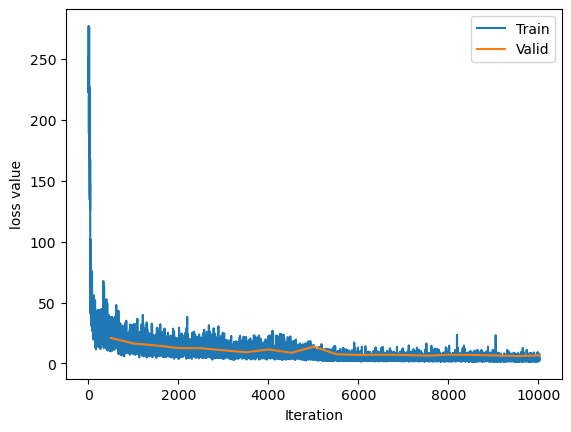

In [25]:
train_x = range(len(train_curve))
train_y = train_curve

train_iters = len(train_dataloader)
valid_x = np.arange(1, len(valid_curve)+1) * train_iters*val_interval # 由于valid中记录的是epochloss，需要对记录点进行转换到iterations
valid_y = valid_curve

plt.plot(train_x, train_y, label='Train')
plt.plot(valid_x, valid_y, label='Valid')

plt.legend(loc='upper right')
plt.ylabel('loss value')
plt.xlabel('Iteration')
plt.show()